# Time series classification

This notebook describes the use of torchctrnn for situations in which the vector space (parameterised by a neural network) - a neural ODE - depends on both time $t$ and the encoded vector $h(t)$. 

The data model for the example is:

...

In [10]:
import math
import matplotlib.pyplot as plt

# deep learning libraries
import torch
import torch.nn as nn
from torchctrnn import ODERNNCell

In [11]:
def get_data(n_trajectories=128,n_samples = 30):
    """
    Simple time series classification task.
    The data generated is `n_trajectories` of irregularly sampled time series, each associated with a binary classification.
    The classification problem is whether a sine waves have a frequency less than 1. 
    """
    
    ts = 10*torch.rand(n_trajectories,n_samples).sort(dim=1)[0]
    freq = 1.0 + 0.1*torch.randn(n_trajectories)
    y = torch.zeros(n_trajectories)
    y[freq < 1.0] = 1.0

    X = torch.zeros(n_trajectories,n_samples)
    for j in range(n_trajectories):
        X[j] = torch.sin(freq[j]*ts[j])

    return X,y,ts

In [12]:
# training data
X,y,t = get_data(n_trajectories=256)

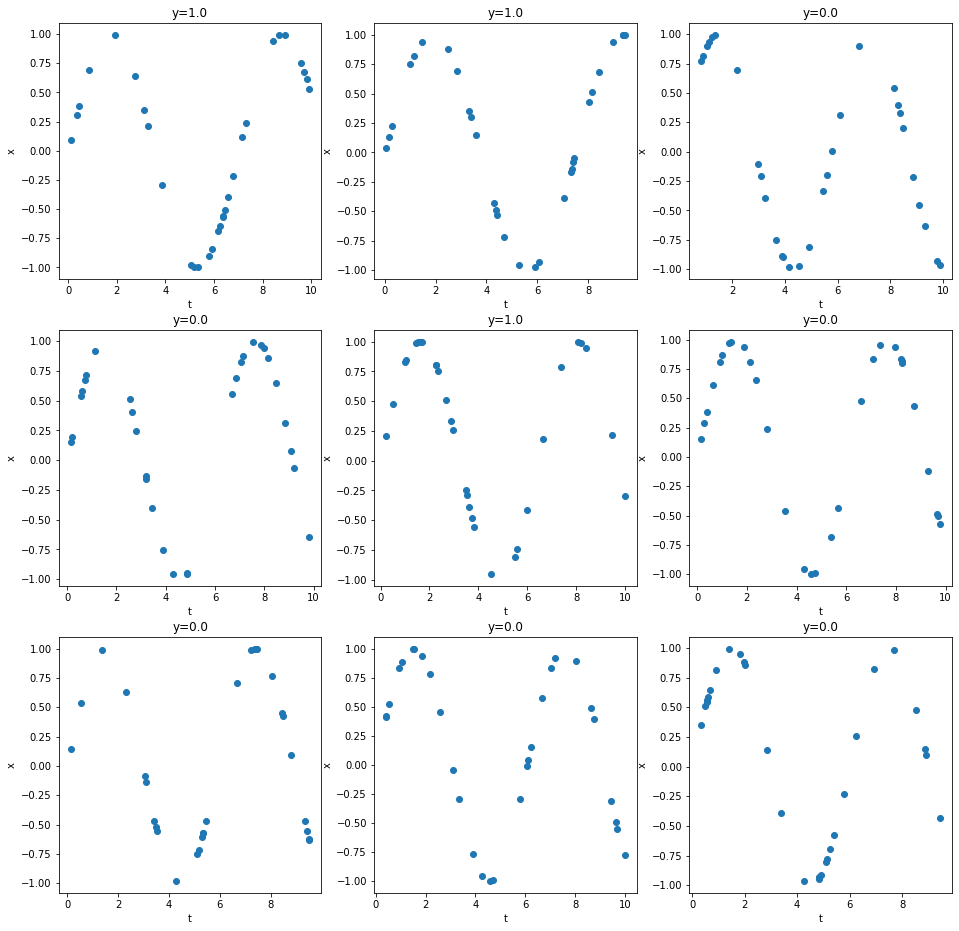

In [13]:
# example plots
n_plot = 3
fig, ax = plt.subplots(n_plot,n_plot,figsize=(16,16))
k = 0
for i in range(n_plot):
    for j in range(n_plot):
        ax[i,j].scatter(t[k],X[k])
        ax[i,j].set_title('y={}'.format(y[k].item()))
        ax[i,j].set_xlabel('t')
        ax[i,j].set_ylabel('x')
        k += 1
plt.show()

The cell below sets up our networks.

In [14]:
class ODENet(nn.Module):
    """"
    Subnetwork
    This neural network defines the vector space
    Time dependent
    """

    def __init__(self,hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.net = nn.Sequential(
            nn.Linear(1+hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size),
        )

    def forward(self,input, t, dt, hidden):
        z = torch.cat((t,hidden),1)
        return self.net(z)


class MainNet(nn.Module):
    """
    Full network
    """

    def __init__(self,ODENet,input_size,hidden_size,output_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.odenet = ODERNNCell(ODENet,input_size,hidden_size)
        self.decode = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, output_size),
            nn.Sigmoid(),
        )

    def forward(self,times,x):
        """
        Forward method for the main model

        x = (batch,timestep,features)
        times = 
        """

        J = x.size(1)
        batch_size = x.size(0)
        output = torch.zeros(batch_size,J,self.output_size)
        h = torch.zeros(batch_size,self.hidden_size)
        for j in range(0,J):
            xj = x[:,j,:]
            times_j = times[:,j,:]
            h = self.odenet(xj,h,times_j).squeeze(0)
            output[:,j,:] = self.decode(h)
        return output[:,J-1,:]

In [15]:
x_size = 1  # number of input features
hidden_size = 4
output_size = 1

odenet = ODENet(hidden_size)
model = MainNet(odenet,x_size,hidden_size,output_size)

optimizer = torch.optim.Adam(model.parameters())

In [16]:
# the time data needs to be (start,stop)
# the last stop time could be set as 10 
# but we'll just drop the final X for simplicity
nt = t.shape[1]
time_gaps = torch.cat((t[:,0:(nt-1)].unsqueeze(2),t[:,1:].unsqueeze(2)),2)
print(time_gaps.shape)
X = X[:,0:(nt-1)]


torch.Size([256, 29, 2])


In [17]:
num_epochs = 20
train_dataset = torch.utils.data.TensorDataset(X.unsqueeze(2),y,time_gaps)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
for epoch in range(num_epochs):
    for batch in train_dataloader:
        x_batch,y_batch,t_batch = batch
        y_pred = model(t_batch,x_batch).squeeze(-1)
        loss = torch.nn.functional.binary_cross_entropy(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))

Epoch: 0   Training loss: 0.6386250853538513
Epoch: 1   Training loss: 0.6148615479469299
Epoch: 2   Training loss: 0.580071747303009
Epoch: 3   Training loss: 0.5328897833824158
Epoch: 4   Training loss: 0.46706515550613403
Epoch: 5   Training loss: 0.38811153173446655
Epoch: 6   Training loss: 0.32311996817588806
Epoch: 7   Training loss: 0.2826085388660431
Epoch: 8   Training loss: 0.25520017743110657
Epoch: 9   Training loss: 0.23409505188465118
Epoch: 10   Training loss: 0.21788665652275085
Epoch: 11   Training loss: 0.205734521150589
Epoch: 12   Training loss: 0.1967276930809021
Epoch: 13   Training loss: 0.19027790427207947
Epoch: 14   Training loss: 0.18554002046585083
Epoch: 15   Training loss: 0.18201611936092377
Epoch: 16   Training loss: 0.1799064427614212
Epoch: 17   Training loss: 0.17901518940925598
Epoch: 18   Training loss: 0.17870491743087769
Epoch: 19   Training loss: 0.17873410880565643


In [22]:
X_test,y_test,t_test = get_data()
t_gaps_test = torch.cat((t_test[:,0:(nt-1)].unsqueeze(2),t_test[:,1:].unsqueeze(2)),2)
X_test = X_test[:,0:(nt-1)].unsqueeze(2)
y_pred = model(t_gaps_test,X_test).squeeze(-1)
y_pred_binary = (y_pred > 0.5).to(y_test.dtype)
prediction_matches = (y_pred_binary == y_test).to(y_test.dtype)
proportion_correct = prediction_matches.sum() / y_test.size(0)
print('Test Accuracy: {}'.format(proportion_correct))
print('Positive class: {}'.format(torch.sum(y_test)/y_test.shape[0]))

Test Accuracy: 0.8671875
Positive class: 0.515625
